In [1]:
# If gspx is not installed, we add it to the path
import os, sys
gdir = os.path.dirname(os.getcwd())  # parent folder
sys.path.insert(0, gdir)

In [2]:
import numpy as np

from gspx.utils.display import plot_graph
from gspx.datasets import WeatherGraphData, uk_weather
from gspx.signals import QuaternionSignal
from gspx.qgsp import create_quaternion_weights, QGFT, QMatrix

In [3]:
uk_data = WeatherGraphData()
Ar, coords = uk_data.graph
s = uk_data.signal

In [4]:
df = uk_weather()

Aq = create_quaternion_weights(
    Ar, df, icols=['humidity'], jcols=['temp'],
    kcols=['wind_speed'])

100%|██████████| 2014/2014 [00:03<00:00, 609.83it/s]


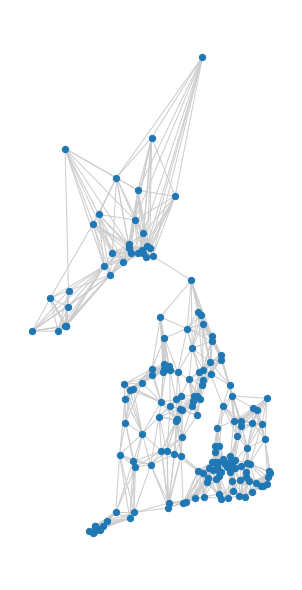

In [5]:
plot_graph(
    Aq.abs(), coords=coords,
    figsize=(4, 8), colormap='viridis',
    node_size=40)

In [6]:
qgft = QGFT()
qgft.fit(Aq)

Running eigendecomposition of the shift operator.
Sorting the frequencies based on Total Variation.


## Creating a quaternionic heat kernel

In [13]:
# Heat kernel in all 4 quaternion dimensions
k = 0.2
ss = np.zeros(len(qgft.idx_freq))
ss[qgft.idx_freq] = np.exp(-k * np.arange(len(qgft.idx_freq)))

ss = QuaternionSignal.from_rectangular(
    np.hstack([ss[:, np.newaxis]] * 4)
)

In [14]:
rnd = np.random.RandomState(seed=42)
err_amplitude = 0.15

nn = QuaternionSignal.from_equal_dimensions(
    rnd.uniform(low=-err_amplitude, high=err_amplitude, size=len(ss))
)

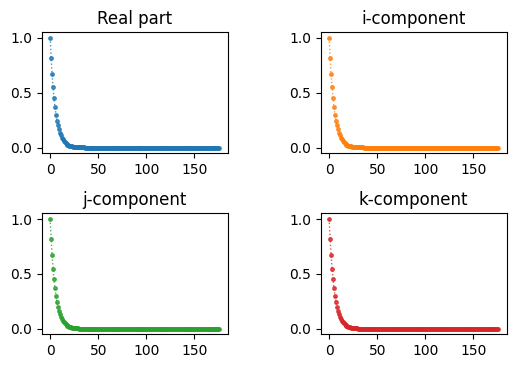

In [15]:
QuaternionSignal.show(ss, ordering=qgft.idx_freq)

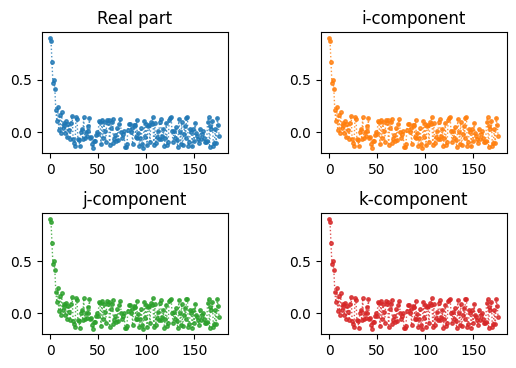

In [17]:
QuaternionSignal.show(ss + nn, ordering=qgft.idx_freq)

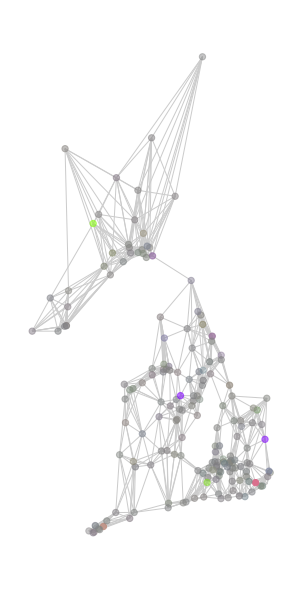

In [18]:
s = qgft.inverse_transform(ss)

obj = QuaternionSignal.from_samples(s.matrix.ravel())
node_color = [tuple(rgba) for rgba in obj.to_rgba()]

plot_graph(
    Aq.abs(), coords=coords, colors=node_color,
    figsize=(4, 8), colormap='viridis',
    node_size=40)

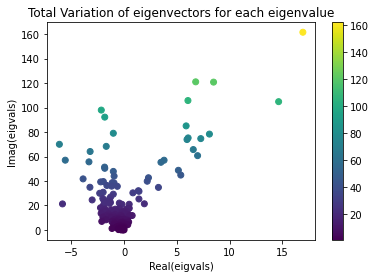

In [19]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(np.real(qgft.eigc), np.imag(qgft.eigc), c=qgft.tv_)
plt.colorbar()
plt.title("Total Variation of eigenvectors for each eigenvalue")
plt.xlabel("Real(eigvals)")
plt.ylabel("Imag(eigvals)")
plt.show()

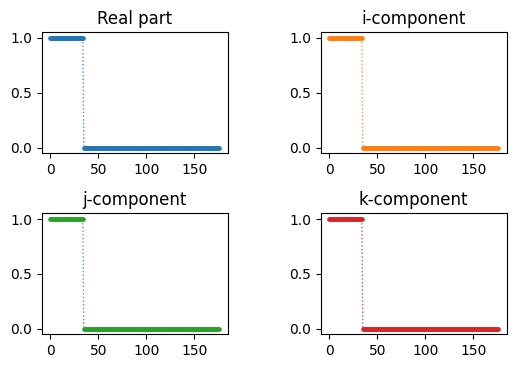

In [20]:
h_ideal = np.zeros(len(qgft.idx_freq))

# Bandwith of 20% the frequency support
bandwidth = int(len(qgft.idx_freq) / 5)
h_ideal[qgft.idx_freq[:bandwidth]] = 1

h_idealq = QuaternionSignal.from_rectangular(np.hstack((
    h_ideal[:, np.newaxis],
    h_ideal[:, np.newaxis],
    h_ideal[:, np.newaxis],
    h_ideal[:, np.newaxis]
)))
QuaternionSignal.show(h_idealq, ordering=qgft.idx_freq)

In [21]:
from gspx.qgsp import QMatrix
deg = 7

X = QMatrix.vander(qgft.eigq, deg, increasing=True)
y = h_idealq
print(X.shape, y.shape)

(177, 7) (177, 1)


LR: 1:  10%|█         | 10/100 [00:02<00:24,  3.74it/s]


Early stopping due to increasing cost in the last 10 iterations.


LR: 1.3:  10%|█         | 10/100 [00:02<00:23,  3.88it/s]


Early stopping due to increasing cost in the last 10 iterations.


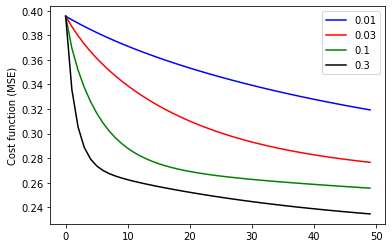

In [22]:
from gspx.adaptive import QLMS

qlms = QLMS()
qlms.fit(X, y)
qlms.plot()

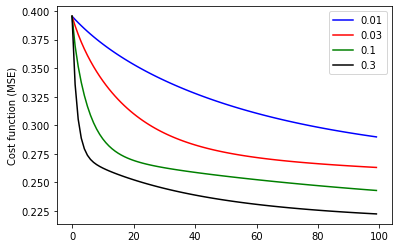

In [29]:
qlms.plot(nsamples=100)

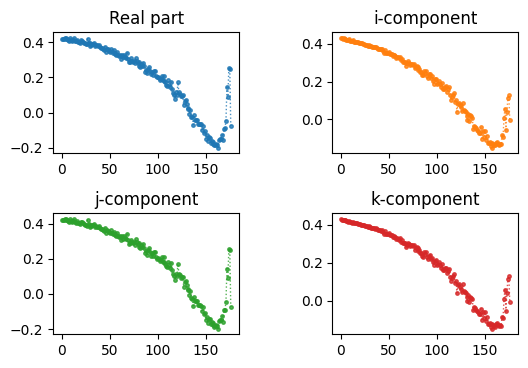

In [23]:
h_opt = qlms.predict(X)
h_opt = QuaternionSignal.from_samples(h_opt.matrix.ravel())
QuaternionSignal.show(h_opt, ordering=qgft.idx_freq)

In [24]:
sn = qgft.inverse_transform(ss + nn)

In [25]:
print("MSE prior:", np.mean((s - sn).abs()**2))

MSE prior: 0.03055859879457719


In [26]:
ssn_lpf = (ss + nn).hadamard(h_opt)
s_lpf = qgft.inverse_transform(ssn_lpf)

print("MSE post:", np.mean((s - s_lpf).abs()**2))

MSE post: 0.06605445520828622


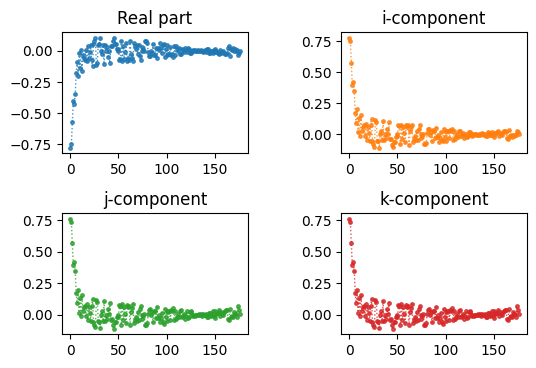

In [28]:
QuaternionSignal.show(ssn_lpf, ordering=qgft.idx_freq)